In this experiment we gonna try to initialize Transformer model with good embeddings, learnt from monolingual corpora.

In [1]:
import sys; sys.path.append('..')

import os
import json
import argparse
from random import choice
from time import time
from datetime import timedelta

import numpy as np; np.random.seed(42)
import tensorflow as tf
from tqdm import tqdm
import matplotlib.pyplot as plt
from pandas import ewma
from IPython.display import clear_output

from vocab import Vocab
from src.training_utils import *
from lib.tensor_utils import infer_mask, initialize_uninitialized_variables, all_shapes_equal
from lib.utils import save_score

from models.transformer_other import Model as Transformer

/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
Using TensorFlow backend.


In [2]:
import os
from os import path

config = {
    'data_path': '../data/generated',
    'hp_file_path': '../hp_files/trans_default.json',
    'use_early_stopping': True,
    'early_stopping_last_n': 10,
    'max_epochs': 1000,
    'max_time_seconds': 600,
    'batch_size_for_inference': 16,
    'max_len': 200,
    'validate_every_num_epochs': 5,
    'warm_up_num_epochs': 10
}

model_name = 'transformer_embs_init'
model_path = path.join('../trained_models', model_name)
if not os.path.isdir(model_path): os.mkdir(model_path)

src_train_path = path.join(config.get('data_path'), 'src_train.tok.bpe')
trg_train_path = path.join(config.get('data_path'), 'trg_train.tok.bpe')
src_val_path = path.join(config.get('data_path'), 'src_val.tok.bpe')
trg_val_path = path.join(config.get('data_path'), 'trg_val.tok.bpe')
# src_mono_path = path.join(config.get('data_path'), 'src_mono.tok.bpe')
# trg_mono_path = path.join(config.get('data_path'), 'trg_mono.tok.bpe')

src_train = open(src_train_path, 'r', encoding='utf-8').read().splitlines()
trg_train = open(trg_train_path, 'r', encoding='utf-8').read().splitlines()
src_val = open(src_val_path, 'r', encoding='utf-8').read().splitlines()
trg_val = open(trg_val_path, 'r', encoding='utf-8').read().splitlines()
# src_mono = open(src_mono_path, 'r', encoding='utf-8').read().splitlines()
# trg_mono = open(trg_mono_path, 'r', encoding='utf-8').read().splitlines()

vocab_src = Vocab.from_file(path.join(config.get('data_path'), 'vocab.src'))
vocab_trg = Vocab.from_file(path.join(config.get('data_path'), 'vocab.trg'))
max_len = config.get('max_len', 200)

# Hyperparameters
hp = json.load(open(config.get('hp_file_path'), 'r', encoding='utf-8')) if config.get('hp_file_path') else {}

In [3]:
# gpu_options = create_gpu_options(config)
# sess = tf.InteractiveSession(config=tf.ConfigProto(gpu_options=gpu_options))
sess = tf.InteractiveSession()

# Disabling GPU
# tf_config = tf.ConfigProto(device_count = {'GPU': 0})
# sess = tf.InteractiveSession(config=tf_config)

In [4]:
main_optimizer = create_optimizer(hp)
embs_optimizer = create_optimizer({'lr': 1e-4, 'beta2': 0.98})


inp = tf.placeholder(tf.int32, [None, None])
out = tf.placeholder(tf.int32, [None, None])

In [5]:
def load_embeddings(embeddings_path):
    embeddings = {}

    with open(embeddings_path, 'r', encoding='utf-8') as f:
        next(f) # Skipping first line, because it's header info
        for line in f:
            values = line.rstrip().rsplit(' ')
            word = values[0]
            embeddings[word] = np.asarray(values[1:], dtype='float32')

    return embeddings


def create_emb_matrix(embeddings, vocab):
    emb_size = embeddings[list(embeddings.keys())[0]].shape[0]
    emb_matrix = np.random.standard_normal((len(vocab), emb_size))
    
    for word, idx in vocab.token2id.items():
        if not word in embeddings:
            # Such tokens like BOS and EOS do not have learnt embeddings
            continue

        emb_matrix[idx] = embeddings[word]
        
    return emb_matrix

In [6]:
embeddings_src = load_embeddings('../trained_models/embeddings/src.tok.bpe_cbow.vec')
embeddings_trg = load_embeddings('../trained_models/embeddings/trg.tok.bpe_cbow.vec')

emb_matrix_src = create_emb_matrix(embeddings_src, vocab_src)
emb_matrix_trg = create_emb_matrix(embeddings_trg, vocab_trg)

In [7]:
#############################################
### Initializing our main model
#############################################
model = Transformer(model_name, vocab_src, vocab_trg, **hp)

logprobs = model.symbolic_score(inp, out, is_train=True)[:,:tf.shape(out)[1]]
nll = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logprobs, labels=out)
loss = nll * infer_mask(out, vocab_trg.eos, dtype=tf.float32)
loss = tf.reduce_sum(loss, axis=1)
loss = tf.reduce_mean(loss)
weights = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, model_name)

# We should apply gradients for pretrained embeddings more gently
# So we have a separate optimizer for them
embs_src = next(w for w in weights if 'emb_inp/mat' in w.name)
embs_trg = next(w for w in weights if 'emb_out/mat' in w.name)
embs_weights = [embs_src, embs_trg]
main_weights = [w for w in weights if not w in embs_weights]

main_grads = tf.gradients(loss, main_weights)
embs_grads = tf.gradients(loss, embs_weights)

main_grads = tf.clip_by_global_norm(main_weights, 100)[0]
embs_grads = tf.clip_by_global_norm(embs_grads, 100)[0]

main_train_step = main_optimizer.apply_gradients(zip(main_grads, main_weights))
embs_train_step = embs_optimizer.apply_gradients(zip(embs_grads, embs_weights))

train_step = tf.group(main_train_step, embs_train_step)
#############################################

In [8]:
batch_size = hp.get('batch_size', 32)
epoch = 0
training_start_time = time()
loss_history = []
val_scores = []

num_iters_done = 0
should_start_next_epoch = True # We need this var to break outer loop

# Initializing embeddings with pretrained ones
# sess.run([tf.assign(embs_src, emb_matrix_src), tf.assign(embs_trg, emb_matrix_trg)]);

initialize_uninitialized_variables(sess)

In [9]:
def save_model():
    save_path = '{}/model.npz'.format(model_path)
    print('Saving the model into %s' %save_path)

    w_values = sess.run(weights)
    weights_dict = {w.name: w_val for w, w_val in zip(weights, w_values)}
    np.savez(save_path, **weights_dict)

def validate(val_scores):
    """
    Returns should_continue flag, which tells us if we should continue or early stop
    """
    should_continue = True

    # if config.get('warm_up_num_epochs') and config.get('warm_up_num_epochs') > epoch:
    #     print('Skipping validation, becaused is not warmed up yet')
    #     return should_continue

    print('Validating')
    val_score = compute_bleu_for_model(model, sess, inp_voc, out_voc, src_val, dst_val,
                                        model_name, config, max_len=max_len)
    val_scores.append(val_score)
    print('Validation BLEU: {:0.3f}'.format(val_score))

    # Save model if this is our best model
    if np.argmax(val_scores) == len(val_scores)-1:
        print('Saving model because it has the highest validation BLEU.')
        save_model()

    if config.get('use_early_stopping') and should_stop_early(val_scores, config.get('early_stopping_last_n')):
        print('Model did not improve for last %s steps. Early stopping.' % config.get('early_stopping_last_n'))
        should_continue = False

    if config.get('warm_up_num_epochs') > epoch:
        return True
    else:
        return should_continue

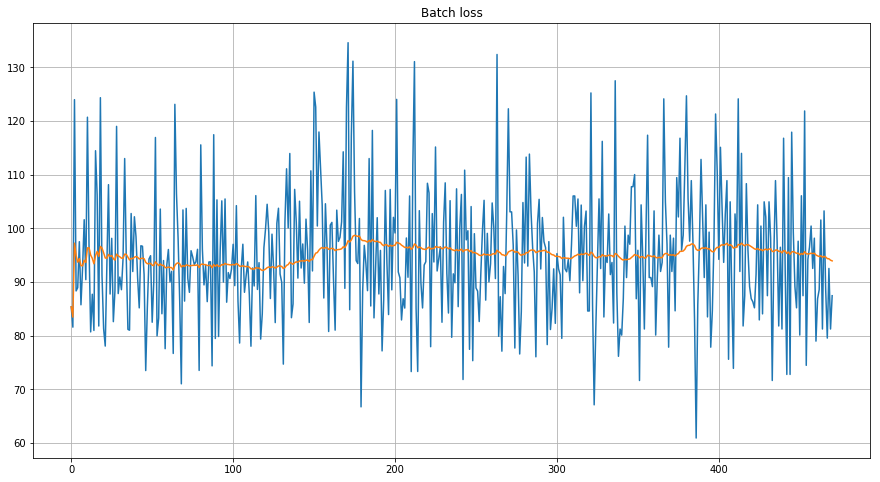

472it [03:39,  2.15it/s]


KeyboardInterrupt: 

In [10]:
while should_start_next_epoch:
    batches = batch_generator_over_dataset(src_train, trg_train, batch_size, batches_per_epoch=None)
    with tqdm(batches) as t:
        for batch_src, batch_trg in t:
            # Note: we don't use voc.tokenize_many(batch, max_len=max_len)
            # cuz it forces batch length to be that long and we often get away with much less
            batch_src_ix = vocab_src.tokenize_many(batch_src)[:, :max_len]
            batch_trg_ix = vocab_trg.tokenize_many(batch_trg)[:, :max_len]

            feed_dict = {inp: batch_src_ix, out: batch_trg_ix}

            loss_t = sess.run([train_step, loss], feed_dict)[1]
            loss_history.append(np.mean(loss_t))

            loss_hist_val = ewma(np.array(loss_history[-50:]), span=50)[-1]
            
            if num_iters_done % 10 == 0:
                clear_output(True)
                plt.figure(figsize=[15,8])
                plt.title('Batch loss')
                plt.plot(loss_history)
                plt.plot(ewma(np.array(loss_history),span=100))
                plt.grid()
                plt.show()

            num_iters_done += 1

            if config.get('max_time_seconds'):
                seconds_elapsed = time()-training_start_time

                if seconds_elapsed > config.get('max_time_seconds'):
                    print('Maximum allowed training time reached. Training took %s. Stopping.' % seconds_elapsed)
                    should_start_next_epoch = False
                    break

        if epoch % config.get('validate_every_num_epochs') == 0 and should_start_next_epoch:
            should_start_next_epoch = validate()

        if config.get('max_epochs') and config.get('max_epochs') == epoch:
            print('Maximum amount of epochs reached. Stopping.')
            should_start_next_epoch = False
            break

        epoch +=1